In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import scipy

sns.set()

In [2]:
beta=2/3
gamma=-0.1
zeta=1.1
loc0=0

init_mean=0
init_std=0.01

In [8]:
def sigmoid(x):
    return 1/(1+np.exp(-x))


def elbo_sigmoid(alpha=1, beta=2/3, gamma=-0.1, zeta=1.1):
    lambda_val = zeta-gamma
    loc = np.log(alpha)
    
    def int_fun(u):
        return (1/beta)*(u*np.log(u*alpha) + (1-u)*np.log(1-u) - 1)

    u0 = get_u0(loc, beta, gamma, zeta)
    u1 = get_u1(loc, beta, gamma, zeta)
    
    e_fun = int_fun(u1)-int_fun(u0)
    
    return sigmoid(e_fun)


def compute_vf(u=1/2, loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    s=sigmoid((np.log(u) - np.log(1-u) + loc)/beta)
    s=s*(zeta-gamma) + gamma

    z = np.clip(s, 0, 1)
    return z


def compute_f(u=1/2, loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    s=sigmoid((np.log(u) - np.log(1-u) + loc)/beta)
    s=s*(zeta-gamma)
    
    return s


def get_integral(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    alpha = np.exp(loc)
    lambda_val = zeta-gamma
    u0 = get_u0(loc=loc, beta=beta)
    u1 = get_u1(loc=loc, beta=beta)
    f_int = scipy.integrate.quad(lambda x: compute_f(x, loc=loc, beta=beta_val), u0, u1)[0]
#     f_int = lambda_val*elbo_sigmoid(alpha, beta, gamma, zeta)
#     def t_from_u(u):
#         return (np.log(u/(1-u)) + loc)/beta

#     def g_func_int(t):
#         return sigmoid(t)*(1-sigmoid(t))*sigmoid(beta*t-loc)
    
#     def g_func(t):
#         return sigmoid(t)*sigmoid(beta*t-loc)
# #         return lambda_val*sigmoid(t)
#     g_func = lambda u: (lambda_val*beta/2)*sigmoid((np.log(u/(1-u))+loc)/beta)*sigmoid(np.log(u/(1-u)))
#     f_int = scipy.integrate.quad(g_func, t_from_u(u0), t_from_u(u1))[0]
#     f_int = (lambda_val/2)*(g_func(t_from_u(u1))-g_func(t_from_u(u0))) - lambda_val*scipy.integrate.quad(g_func_int,
#                                                                                        t_from_u(u0),
#                                                                                        t_from_u(u1))[0]
    f_int += gamma*(u1-u0) +(1-u1)
    
    return f_int



def int_func(u, alpha=0, beta=2/3, gamma=-0.1, zeta=1.1):
#     u_pow = np.power(alpha*u, 1/beta)
#     print(alpha)
    u_pow = (alpha*u)**(1/beta)
#     res = u_pow/(u_pow+np.power(1-u, 1/beta))
    res = u_pow/(u_pow+(1-u)**(1/beta))
    res = u*(res*((zeta-gamma)*beta/2) - gamma)
    
#     t = lambda u: np.log(u)-np.log(1-u)+np.log(alpha)
    
    return res


def integrate(u_low, u_up, alpha=0, beta=2/3, gamma=-0.1, zeta=1.1):
    return int_func(u_up, alpha, beta, gamma, zeta) \
            - int_func(u_low, alpha, beta, gamma, zeta)


def get_z_expected(alpha=0, beta=2/3, gamma=-0.1, zeta=1.1):
    loc = np.log(alpha)
    u0 = get_u0(loc, beta, gamma, zeta)
    u1 = get_u1(loc, beta, gamma, zeta)
    f1 = 0
    u0 = np.clip(u0, 0, 1)
    u1 = np.clip(u1, 0, 1)
    assert u1 > u0
    
    f1 = integrate(u0, u1, alpha, beta, gamma, zeta) 
    res = f1 + (1-u1)
    return res


def propose_test_time_gate(loc=0, beta=2/3, gamma=-0.1, zeta=1.1, thres=0.1):
    p_z = prob_nonzero(loc, beta, gamma, zeta)
    e_z = get_z_expected(np.exp(loc), beta, gamma, zeta)
    if p_z > thres:
        return e_z
    else:
        return 0


def get_u0(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    k = loc + (beta*np.log(-zeta/gamma))
    return sigmoid(-k)


def get_u1(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    k = loc + (beta*np.log(-(zeta-1)/(gamma-1)))
    return sigmoid(-k)


def prob_z_inter(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    k = loc + (beta*np.log(-zeta/gamma))
    k1 = loc + (beta*np.log(-(zeta-1)/(gamma-1)))
    
    return 1 - (sigmoid(-k) + sigmoid(k1))


def prob_one(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    k1 = loc + (beta*np.log(-(zeta-1)/(gamma-1)))
    return sigmoid(k1)


def prob_nonzero(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    k = loc + beta*np.log(-zeta/gamma)
    return sigmoid(k)


def prob_nonzero_paper(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
#     print(sigmoid(np.log(loc)))
    return np.clip(sigmoid(loc)*(zeta-gamma) + gamma, 0, 1)


def prob_nonzero_paper_implementation(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
#     print(sigmoid(np.log(loc)))
    return np.clip(sigmoid(loc)*(zeta-gamma) + gamma, 0, 1)


def delta(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
    pnz_paper = 1 - prob_zero_paper(loc, beta, gamma, zeta)
    pnz_mod = 1 - prob_zero(loc, beta, gamma, zeta)
    
    return pnz_paper-pnz_mod


# def z_expected(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
#     k = loc + beta*np.log(-zeta/gamma)
#     k1 = loc + (beta*np.log(-(zeta-1)/(gamma-1)))
#     lambda_var = zeta - gamma
#     e_g = ((gamma-1)/(gamma-zeta))*(np.power(1-gamma, beta)/(np.power(1-gamma, beta)+np.exp(loc)*np.power(zeta-1, beta)))
#     e_g += ((gamma)/(gamma-zeta))*(np.power(-gamma, beta)/(np.power(-gamma, beta)+np.exp(loc)*np.power(zeta, beta)))
    
#     e_z = gamma*(sigmoid(-k1)-sigmoid(-k)) + (lambda_var*beta/2)*e_g
#     # zero included
#     e_z += prob_one(loc, beta, gamma, zeta)
    
#     return e_z

# def z_expected(loc=0, beta=2/3, gamma=-0.1, zeta=1.1):
# #     k = loc + beta*np.log(-zeta/gamma)
# #     k1 = loc + (beta*np.log(-(zeta-1)/(gamma-1)))
# #     u0 = sigmoid(-k)
# #     u1 = sigmoid(-k1)
# #     lambda_var = zeta - gamma
# #     e_g = integrate(u0, u1, loc, gamma, zeta)
# #     e_g += gamma*(u1-u0)
    
# #     e_z = e_g + sigmoid(k1)
#     e_g = ((gamma-1)/(gamma-zeta))*((np.power(1-gamma, beta))
    
#     return e_z

/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


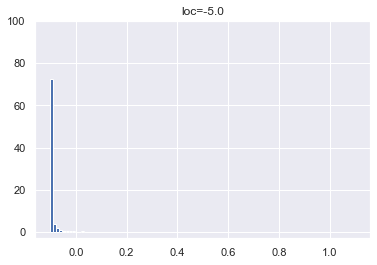

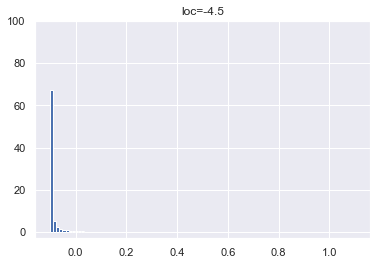

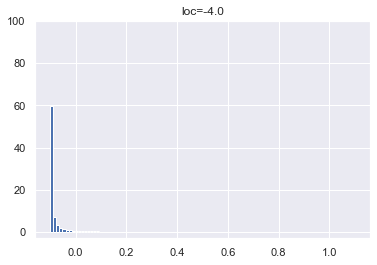

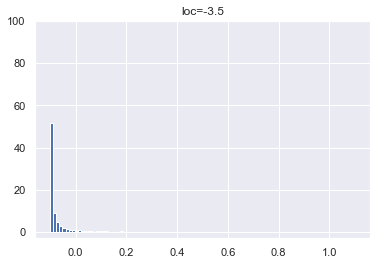

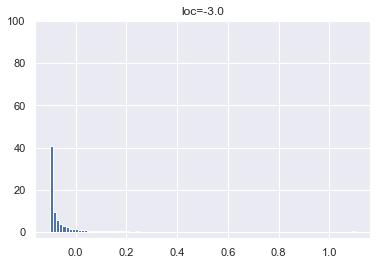

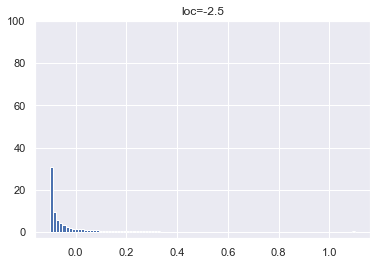

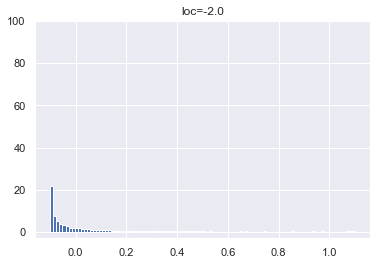

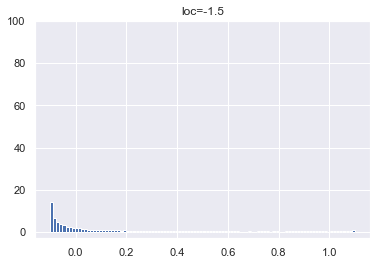

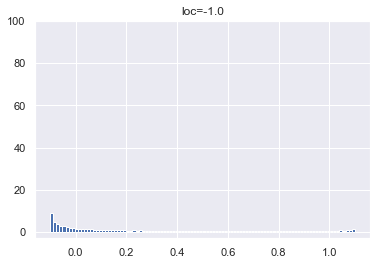

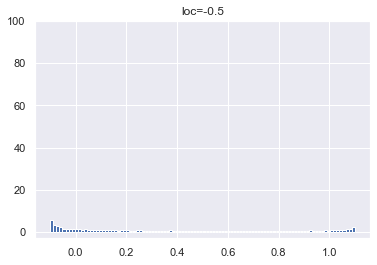

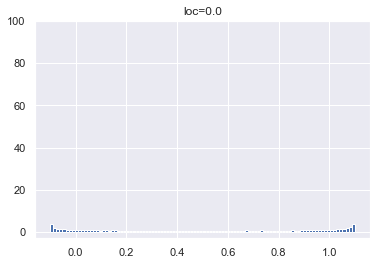

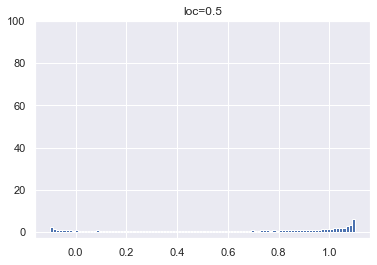

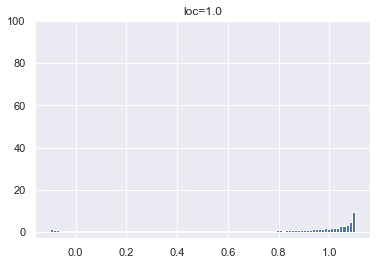

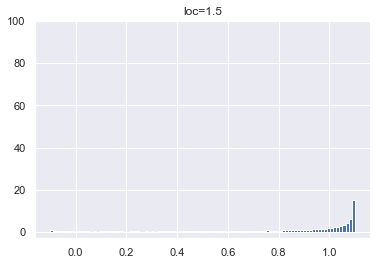

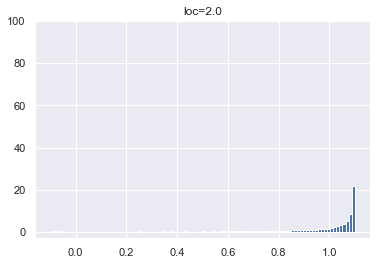

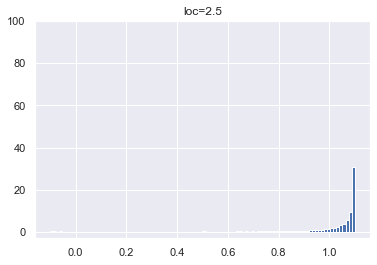

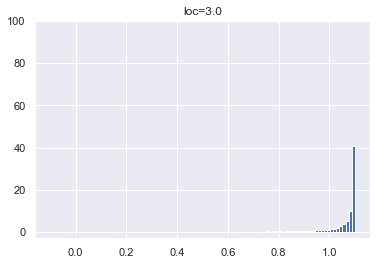

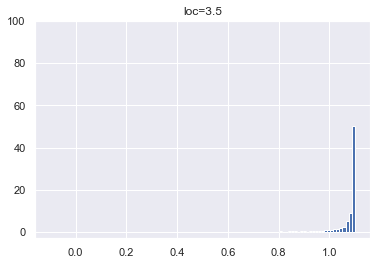

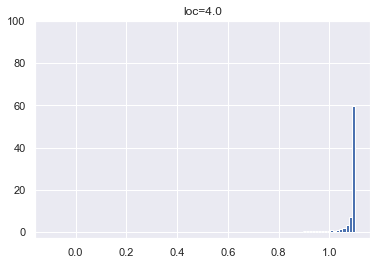

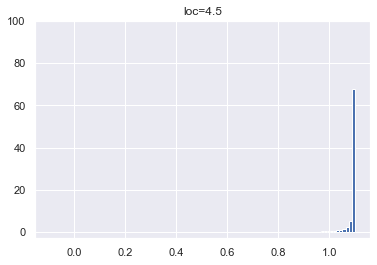

In [6]:
n_samples=10000

for loc in np.arange(-5, 5, 0.5):
    samples_u = np.random.sample(n_samples)
    z_vals = [ compute_vf(u=u_val, loc=loc, beta=2/3) for u_val in samples_u ]

    plt.title("loc={}".format(loc))
    plt.hist(z_vals, bins=100, normed=True)
    plt.ylim((-3, 100))
    plt.show()

NameError: name 'cm' is not defined

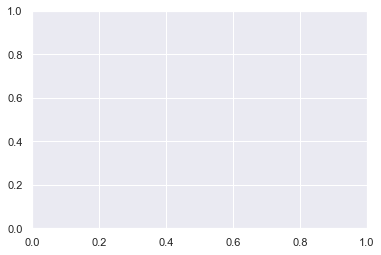

In [5]:
u_vals = np.arange(0.01, 1, 0.01)

for beta_val in [ 0.1, 1/4, 1/2, 2/3, 3/4, 1, 2 ]:
    
    fig = plt.figure(figsize=(6, 4))
    ax1 = fig.add_subplot(111)

    sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_loc, vmax=max_loc))
    ax1.set_prop_cycle(color=[cm(1.*i/np.arange(-20, 20, 1).shape[0]) for i in range(NUM_COLORS)])

    plt.title("Function of z with u for loc=0, beta={}, gamma=-0.1, zeta=1.1".format(beta_val))
#     for loc in np.arange(-20, 20, 1):
    z_vals=[ compute_vf(u=u_val, loc=10, beta=beta_val) for u_val in u_vals ]
    ax1.plot(u_vals, z_vals)
    #     plt.axvline(get_u0(loc=loc), label="u_0", color='g')
    #     plt.axvline(get_u1(loc=loc), label="u_1", color='r')

    fig.colorbar(sm, ax=ax1)
    ax1.set_ylabel("z")
    ax1.set_xlabel("variational parameter u")
    # plt.legend()
#     ax1.set_ylim((-0.1, 1.1))
    plt.show()

print("u0: ", get_u0())
print("u1: ", get_u1())

In [ ]:
locs = np.arange(-20, 20, 0.01)
u_diff = []
for loc in locs:
    u_diff.append(get_u1(loc=loc)-get_u0(loc=loc))
plt.plot(locs, u_diff)
plt.xlabel("location parameter - log(alpha)")
plt.ylabel("u_diff (u1-u0)")
print("if u1<u0: ", (np.array(u_diff) < 0).any())
plt.ylim(-0.1, 1)
plt.show()

In [ ]:
locs = np.arange(-5, 5, 0.01)
z_vals=[ compute_vf(loc=loc) for loc in locs ]

plt.plot(locs, z_vals)
plt.ylabel("Value of z")
plt.xlabel("trained location parameter(alpha)")
plt.show()

/home/arjun/anaconda2/envs/cache_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


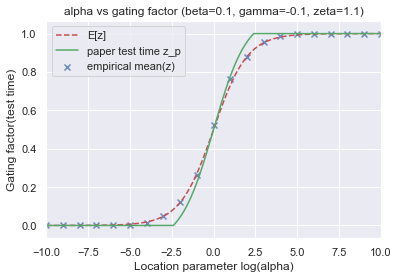

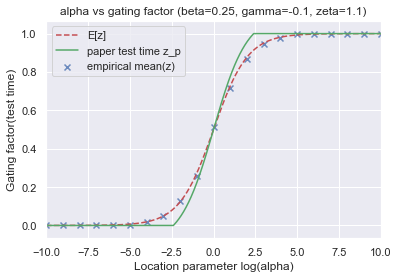

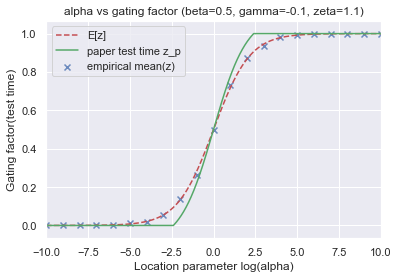

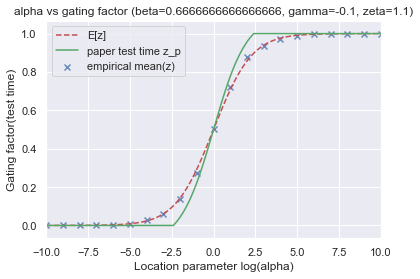

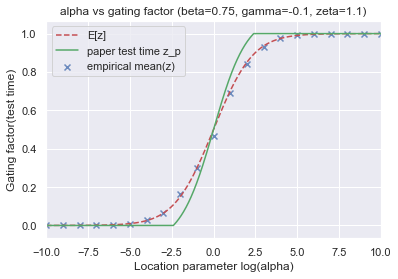

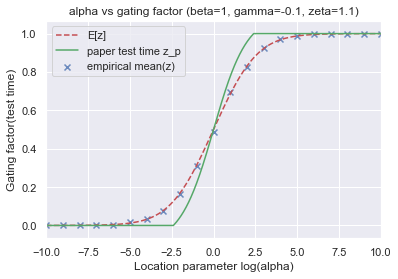

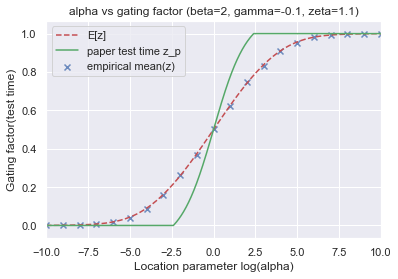

In [9]:
for beta_val in [ 0.1, 1/4, 1/2, 2/3, 3/4, 1, 2 ]:
    locs = np.arange(-20, 20, 0.01)
    loc_logs = [ np.log(loc) for loc in locs ]
    p_zero=[ prob_nonzero(loc=loc, beta=beta_val) for loc in locs ]
    p_zero_paper = [ prob_nonzero_paper(loc=loc, beta=beta_val) for loc in locs ]
    p_zero_paper_implementation = [ prob_nonzero_paper_implementation(loc=loc, beta=beta_val) for loc in locs ]
#     expected_gate = [ get_z_expected(alpha=np.exp(loc), beta=beta_val) for loc in locs ]
    
    expected_gate = [ get_integral(loc=loc, beta=beta_val) for loc in locs ]
#     expected_gate = [ scipy.integrate.quad(lambda x: compute_f(x, loc=loc, beta=beta_val), 
#                                            get_u0(loc=loc, beta=beta_val), 
#                                            get_u1(loc=loc, beta=beta_val))[0] + -0.1*(get_u1(loc=loc, 
#                                                                                        beta=beta_val)
#                                                                                     - get_u0(loc=loc, 
#                                                                                        beta=beta_val)
#                                                                                     ) +(1-get_u1(loc=loc, 
#                                                                                        beta=beta_val)) 
#                      for loc in locs ]

#     proposed_gate = [ propose_test_time_gate(loc=loc, beta=beta_val) for loc in locs ]
    f = [ loc/(loc+1) for loc in locs ]
    sample_pnonzero=[]
    
    for loc in np.arange(-20, 20, 1):
        u_vals = np.random.uniform(0, 1, 1000)
        sample_pnonzero.append(np.mean([ compute_vf(u=u_val, loc=loc, beta=beta_val) for u_val in u_vals ]))

    plt.title("alpha vs gating factor (beta={}, gamma=-0.1, zeta=1.1)".format(beta_val))
    plt.ylabel("Gating factor(test time)")
    plt.xlabel("Location parameter log(alpha)")
    # plt.plot(locs, p_zero, label="theoretical p(z>0)")
#     print(expected_gate)
    plt.plot(locs, expected_gate, "r--", label="E[z]")
    plt.scatter(np.arange(-20, 20, 1), sample_pnonzero, label="empirical mean(z)", alpha=0.8, marker='x')
    # plt.plot(locs, expected_gate, label="E[z]")
    plt.plot(locs, p_zero_paper, label="paper test time z_p", color='g')
#     plt.plot(locs, proposed_gate, label="proposed", alpha=0.8)
#     plt.plot()
    # plt.plot(locs, p_zero_paper_implementation, label="in code z_{pi}")
    # plt.xscale('log')
    plt.legend()
    plt.xlim((-10, 10))
#     plt.savefig("/media/arjun/Shared/tmp/gating_factor_1.jpg")
    plt.show()

In [ ]:
u_func = []
for u in np.random.uniform(0, 1, 1000):
    u_func.append((np.log(u)-np.log(1-u)+loc)/(2/3))
plt.hist(u_func)
plt.show()

In [ ]:
beta_val = 1/2
p_z_inter=[ prob_z_inter(loc=loc, beta=beta_val) for loc in locs ]
p_z_one=[ prob_one(loc=loc, beta=beta_val) for loc in locs ]
p_z_zero=[ 1-prob_nonzero(loc=loc, beta=beta_val) for loc in locs ]

plt.title("alpha vs gating factor (beta={}, gamma=-0.1, zeta=1.1)".format(beta_val))
plt.ylabel("Probability")
plt.xlabel("Location parameter(trained) alpha")
plt.plot(locs, p_z_inter, label="0<z<1")
plt.plot(locs, p_z_one, label="z=1")
plt.plot(locs, p_z_zero, label="z=0")
plt.legend()
# plt.savefig("/media/arjun/Shared/tmp/gating_factor_1.jpg")

In [ ]:
beta_vals = np.arange(0.1, 2.5, 0.5)
for beta_val in beta_vals:
    u0_vals = []
    u1_vals = []
    
    u0_vals = [ get_u0(loc=loc, beta=beta_val) for loc in locs ]
    u1_vals = [ get_u1(loc=loc, beta=beta_val) for loc in locs ]
    
    plt.title("Beta={}".format(beta_val))
    plt.plot(locs, u0_vals, label="u0")
    plt.plot(locs, u1_vals, label="u1")
    plt.xlim((-10, 10))
    plt.legend()
    plt.show()

## Variation of hard sigmoid on location parameter

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

min_loc=-5
max_loc=5
loc_step=0.5
locs=np.arange(min_loc, max_loc, loc_step)

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = locs.shape[0]

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_loc, vmax=max_loc))
ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

zero_fraction=[]
for loc in locs:
    x_list = []
    y_list = []
    y_hc_list = []
    zero_count = 0
    total_vals = 0
    for x in np.arange(0, 1, 0.001):
        total_vals+=1
        x_list.append(x)
        s=sigmoid((np.log(x) - np.log(1-x) + loc)/beta)
        y_list.append(s)
        s=s*(zeta-gamma) + gamma
        
        z = np.clip(s, 0, 1)
        y_hc_list.append(z)
        
        if z == 0:
            zero_count+=1
    
    zero_fraction.append(zero_count/total_vals)

    ax1.plot(x_list, y_list, label="loc={}".format(loc))
    ax1.set_xlabel("u")
    ax1.set_ylabel("sigmoid")
    
    ax2.plot(x_list, y_hc_list, label="loc={}".format(loc))
    ax2.set_xlabel("u")
    ax2.set_ylabel("hard sigmoid")
#     fig.colorbar(sm)

fig.colorbar(sm, ax=ax1)
fig.colorbar(sm, ax=ax2)
plt.tight_layout()
plt.show()

plt.plot(locs, zero_fraction)
plt.ylabel("Fraction of zeros")
plt.xlabel("location parameter")
plt.tight_layout()
plt.show()

y_10_6 = [ (1-frac) * 10**6 for frac in zero_fraction ]
y_10_5 = [ (1-frac) * 10**5 for frac in zero_fraction ]
plt.plot(locs, y_10_6, label="w_max=10^6")
plt.plot(locs, y_10_5, label="w_max=10^5")
plt.xlabel("initial location parameter")
plt.ylabel("number of non zero parameters")
plt.legend()
plt.show()

## Effect of temperature(beta) on the hard sigmoid

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

loc=loc0
const_beta=beta
min_beta=0
max_beta=1
beta_step=0.1
betas=np.arange(min_beta, max_beta, beta_step)

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = betas.shape[0]

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_beta, vmax=max_beta))
ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

zero_fraction=[]
for beta_val in betas:
    x_list = []
    y_list = []
    y_hc_list = []
    zero_count = 0
    total_vals = 0
    for x in np.arange(0, 1, 0.001):
        total_vals+=1
        x_list.append(x)
        s=sigmoid((np.log(x) - np.log(1-x) + loc)/beta_val)
        y_list.append(s)
        s=s*(zeta-gamma) + gamma
        
        z = np.clip(s, 0, 1)
        y_hc_list.append(z)
        
        if z == 0:
            zero_count+=1
    
    zero_fraction.append(zero_count/total_vals)

    ax1.plot(x_list, y_list, label="beta={}".format(beta_val))
    ax1.set_xlabel("u")
    ax1.set_ylabel("sigmoid")
    
    ax2.plot(x_list, y_hc_list, label="beta={}".format(beta_val))
    ax2.set_xlabel("u")
    ax2.set_ylabel("hard sigmoid")
#     fig.colorbar(sm)

fig.colorbar(sm, ax=ax1)
fig.colorbar(sm, ax=ax2)
plt.tight_layout()
plt.show()

plt.plot(betas, zero_fraction)
plt.ylabel("Fraction of zeros")
plt.xlabel("temperature")
plt.tight_layout()
plt.show()

y_10_6 = [ (1-frac) * 10**6 for frac in zero_fraction ]
y_10_5 = [ (1-frac) * 10**5 for frac in zero_fraction ]
plt.plot(betas, y_10_6, label="w_max=10^6")
plt.plot(betas, y_10_5, label="w_max=10^5")
plt.xlabel("temperature")
plt.ylabel("number of non zero parameters")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

loc=loc0
gamma_init=gamma
min_gamma=-10
max_gamma=0
gamma_step=1
gammas=np.arange(min_gamma, max_gamma, gamma_step)

cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = gammas.shape[0]

sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=min_gamma, vmax=max_gamma))
ax1.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

zero_fraction=[]
for gamma_val in gammas:
    x_list = []
    y_list = []
    y_hc_list = []
    zero_count = 0
    total_vals = 0
    for x in np.arange(0, 1, 0.001):
        total_vals+=1
        x_list.append(x)
        s=sigmoid((np.log(x) - np.log(1-x) + loc)/beta)
        y_list.append(s)
        s=s*(zeta-gamma_val) + gamma_val
        
        z = np.clip(s, 0, 1)
        y_hc_list.append(z)
        
        if z == 0:
            zero_count+=1
    
    zero_fraction.append(zero_count/total_vals)

    ax1.plot(x_list, y_list, label="beta={}".format(beta_val))
    ax1.set_xlabel("u")
    ax1.set_ylabel("sigmoid")
    
    ax2.plot(x_list, y_hc_list, label="beta={}".format(beta_val))
    ax2.set_xlabel("u")
    ax2.set_ylabel("hard sigmoid")
#     fig.colorbar(sm)

fig.colorbar(sm, ax=ax1)
fig.colorbar(sm, ax=ax2)
plt.tight_layout()
plt.show()

plt.plot(gammas, zero_fraction)
plt.ylabel("Fraction of zeros")
plt.xlabel("gamma")
plt.tight_layout()
plt.show()

y_10_6 = [ (1-frac) * 10**6 for frac in zero_fraction ]
y_10_5 = [ (1-frac) * 10**5 for frac in zero_fraction ]
plt.plot(gammas, y_10_6, label="w_max=10^6")
plt.plot(gammas, y_10_5, label="w_max=10^5")
plt.xlabel("gamma")
plt.ylabel("number of non zero parameters")
plt.legend()
plt.show()